# Import libraries

In [1]:
import numpy as np
import itertools
import pandas as pd
npPath = '/sharedData2/scratch/fall_npy/'
ncPath = '/sharedData/scratch/'
acmPath = '/sharedData/scratch/all_npy3/'
DATAPATH = '/goesdata'
import re
import os
from os import path as op
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import netCDF4
from pathlib import Path

#refactor to create folders using subprocess library
#from subprocess import

import matplotlib.dates as mdates
from datetime import datetime

/opt/home/adomakor412/.conda/envs/NOAA/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
def getTmean(SS, npPath, band, day):
   
    ncList = os.listdir( ncPath )
    npList = os.listdir( npPath )
    
    look = 'M6C'+ band + '_G' + SS + '_s2019' + day
    acmLook = 'M6_G' + SS + '_s2019' + day
    
    ncFiles = sorted([f for f in ncList if re.search(look,f)])
    npFiles = sorted([f for f in npList if re.search(look,f)])
    
    plot = createUnfilteredPlotArray(ncFiles,npFiles,npPath)
    return plot

In [3]:
def getFilteredTmean(SS, npPath, band, day):
   
    ncList = os.listdir( ncPath )
    npList = os.listdir( npPath )
    acmList = os.listdir( acmPath )
    
    look = 'M6C'+ band + '_G' + SS + '_s2019' + day
    acmLook = 'M6_G' + SS + '_s2019' + day
    
    ncFiles = sorted([f for f in ncList if re.search(look,f)])
    npFiles = sorted([f for f in npList if re.search(look,f)])
    acmFiles = sorted([f for f in acmList if re.search(acmLook,f)])
    plot = createFilteredPlotArray(ncFiles,npFiles,npPath,acmFiles)
    return plot


In [4]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [5]:
def createFilteredPlotArray(ncFiles,npFiles,npPath,acmFiles):#Filtered Histrogram for cloud clear sky mask
    Tmean= []
    times = []
    for ncf, npf, acm in zip(ncFiles, npFiles, acmFiles):
        imageBox = np.load(op.join(npPath,npf))
        acmBox = np.load(op.join(acmPath,acm))
        myFile = xr.open_dataset(op.join(ncPath,ncf))
        planck_fk1 = float(myFile['planck_fk1'].data)
        planck_fk2 = float(myFile['planck_fk2'].data) 
        planck_bc1 = float(myFile['planck_bc1'].data)                       
        planck_bc2 = float(myFile['planck_bc2'].data)     
        T = Rad2BT(imageBox[acmBox==1].mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        tString = ncf[34:38]
        times.append(tString)
        Tmean.append(T)
    return times, Tmean
    

In [6]:
def createUnfilteredPlotArray(ncFiles,npFiles,npPath):#Filtered Histrogram for cloud clear sky mask
    Tmean= []
    times = []
    for ncf, npf in zip(ncFiles, npFiles):
        imageBox = np.load(op.join(npPath,npf))
        myFile = xr.open_dataset(op.join(ncPath,ncf))
        planck_fk1 = float(myFile['planck_fk1'].data)
        planck_fk2 = float(myFile['planck_fk2'].data) 
        planck_bc1 = float(myFile['planck_bc1'].data)                       
        planck_bc2 = float(myFile['planck_bc2'].data)     
        T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        tString = ncf[31:38]
        times.append(tString)
        Tmean.append(T)
    return times, Tmean




In [14]:
for i in [8]:
    d16=pd.DataFrame()
    d17=pd.DataFrame()
    for j in range(11):
        band = str(i).zfill(2)
        date = 98 + j
        day = str(date).zfill(3)
        
        times17, mean17 = getTmean('17', npPath, band, day)
        times16, mean16 = getTmean('16', npPath, band, day)
        
        dframe17=pd.DataFrame(index=times17,data=np.array(mean17),columns=['Mean_temp (K)'])
        dframe16=pd.DataFrame(index=times16,data=np.array(mean16),columns=['Mean_temp (K)'])
        
        d17=d17.append(dframe17)
        d16=d16.append(dframe16)
        
d16.index.name='Time (DDDHHmm)'
d17.index.name='Time (DDDHHmm)'

d16.to_csv("G16series.csv")
d17.to_csv("G17series.csv")

In [7]:
def getUnfilteredTmean(SS, ncPath, npPath, band, day):
   
    ncList = os.listdir( ncPath )
    npList = os.listdir( npPath )
    
    look = 'M6C'+ band + '_G' + SS + '_s2019' + day
    
    ncFiles = sorted([f for f in ncList if re.search(look,f)])
    npFiles = sorted([f for f in npList if re.search(look,f)])
    plot = createUnfilteredPlotArray(ncFiles,npFiles,npPath)
    return plot

In [ ]:
Tmean = []
times = []
toi = ['0300','0910','1010','1350','1510','2100']
for (bb,dd) in list(itertools.product([8],range(11))):
    for SS in ['16','17']:
        bins = np.linspace(220,250,101)
        fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), constrained_layout=True, sharey = True, sharex = True)
        fig.suptitle(f'GOES-{SS} ABI Band {bb} {8+dd}-Apr-2019', fontsize = 22, fontweight = 'bold')
        BB = str(bb).zfill(2)
        lookup = f'M6C{BB}_G{SS}_s2019{DD}'
        ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
        npFiles = [f for f in os.listdir(npPath) if re.search(lookup,f)]

        for ncf, npf in zip(ncFiles,npFiles):
            imageBox = np.load(op.join(npPath,npf))
            myFile = xr.open_dataset(op.join(ncPath,ncf))
            planck_fk1 = float(myFile['planck_fk1'].data)
            planck_fk2 = float(myFile['planck_fk2'].data) 
            planck_bc1 = float(myFile['planck_bc1'].data)                       
            planck_bc2 = float(myFile['planck_bc2'].data)     
            T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)#unfilterd
            tString = ncf[34:38]
            times.append(tString)
            Tmean.append(T)

            if tString in toi:
                ax = axes[toi.index(tString)]
                hh = tString[:2]
                mm = tString[2:4]
                ax.set_title(f'{hh}:{mm}')
                ax.set_ylabel('density (unitless)',fontsize = 16)
                ax.set_xlabel('Temperature (K)', fontsize = 16)

                Tbox = Rad2BT(imageBox, planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                ax.hist(Tbox.ravel(), bins = bins, density = True, label = 'Temp dist.')
                #ax.plot([T,T], [0,0.3],'r', label = 'something')
                ax.axvline(T, color='r',label = 'NOAA avg.')
            axes[0].legend(loc='upper left')
        fig.savefig('..'+ op.join(DATAPATH,f"Histograms_unfiltered/G_{SS}_band{BB}_04-{str(8+dd).zfill(2)}-2019"))

# Plots for April 8 through 18.

In [26]:
for i in [8]:
    for j in range(11):
        band = str(i).zfill(2)
        date = 98 + j
        day = str(date).zfill(3)
        
        times17, mean17 = getTmean('17', npPath, band, day)
        times16, mean16 = getTmean('16', npPath, band, day)
    
        ptimes17 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times17]
        ptimes16 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times16]
        fig, ax1 = plt.subplots(figsize=(15,5))#constrained_layout=False
        _ = ax1.plot_date(ptimes17, mean17 , label="GOES-17", color='tab:red', marker='+', markersize = 16)
        _ = ax1.plot_date(ptimes16, mean16 , label='GOES-16', color='tab:blue', marker='+', markersize = 16, zorder=-1)
        _ = ax1.set_ylim(220,260)
        _ = ax1.tick_params('both', labelsize=18)
        _ = ax1.legend()
        _ = ax1.set_title(f'Filtered Clear Sky \n Mean Temperatures (K) for a 401 x 1001 Portion\n of Band 08 on 04-{str(8+j)}-2019', fontweight ='bold', fontsize = 22)
        _ = ax1.set_ylabel('Temperature (K)',fontsize = 16)
        _ = ax1.set_xlabel('time (hours)',fontsize = 16)
        _ = ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        
        _ = plt.savefig('..'+ op.join(DATAPATH,f"Mean_temp_filtered/04-{str(8+j).zfill(2)}-2019"))
        

ValueError: unconverted data remains: 0000

In [ ]:
Tmean = []
times = []
toi = ['0300','0910','1010','1350','1510','2100']
for (bb,dd) in list(itertools.product([8],range(11))):
    for SS in ['16','17']:
        bins = np.linspace(220,250,101)
        fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), constrained_layout=True, sharey = True, sharex = True)
        fig.suptitle(f'GOES-{SS} ABI Band 8 {8+dd}-Apr-2019', fontsize = 22, fontweight = 'bold')
        DD = str(98+dd).zfill(3)
        lookup = f'M6C08_G{SS}_s2019{DD}'
        ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
        npFiles = [f for f in os.listdir(npPath) if re.search(lookup,f)]

        for ncf, npf in zip(ncFiles,npFiles):
            imageBox = np.load(op.join(npPath,npf))
            myFile = xr.open_dataset(op.join(ncPath,ncf))
            planck_fk1 = float(myFile['planck_fk1'].data)
            planck_fk2 = float(myFile['planck_fk2'].data) 
            planck_bc1 = float(myFile['planck_bc1'].data)                       
            planck_bc2 = float(myFile['planck_bc2'].data)     
            T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
            tString = ncf[34:38]
            times.append(tString)
            Tmean.append(T)

            if tString in toi:
                ax = axes[toi.index(tString)]
                hh = tString[:2]
                mm = tString[2:4]
                ax.set_title(f'{hh}:{mm}')
                ax.set_ylabel('density (unitless)',fontsize = 16)
                ax.set_xlabel('Temperature (K)', fontsize = 16)

                Tbox = Rad2BT(imageBox, planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                ax.hist(Tbox.ravel(), bins = bins, density = True, label = 'Temp dist.')
                #ax.plot([T,T], [0,0.3],'r', label = 'something')
                ax.axvline(T, color='r',label = 'NOAA avg.')
            axes[0].legend(loc='upper left')
        fig.savefig('..'+ op.join(DATAPATH,f"Histograms_filtered/G_{SS}_04-{str(8+dd).zfill(2)}-2019"))

In [ ]:
def getTmean2(SS, npPath, band, day):
   
    ncList = os.listdir( ncPath )
    npList = os.listdir( npPath )
    
    look = 'M6C'+ band + '_G' + SS + '_s2019' + day
    acmLook = 'M6_G' + SS + '_s2019' + day
    
    ncFiles = sorted([f for f in ncList if re.search(look,f)])
    npFiles = sorted([f for f in npList if re.search(look,f)])
    
    plot = createUnfilteredPlotArray(ncFiles,npFiles,npPath)
    return plot

# Fall Data

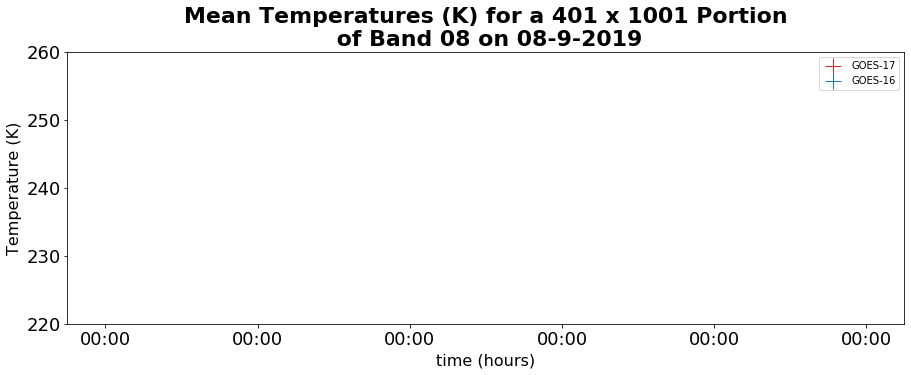

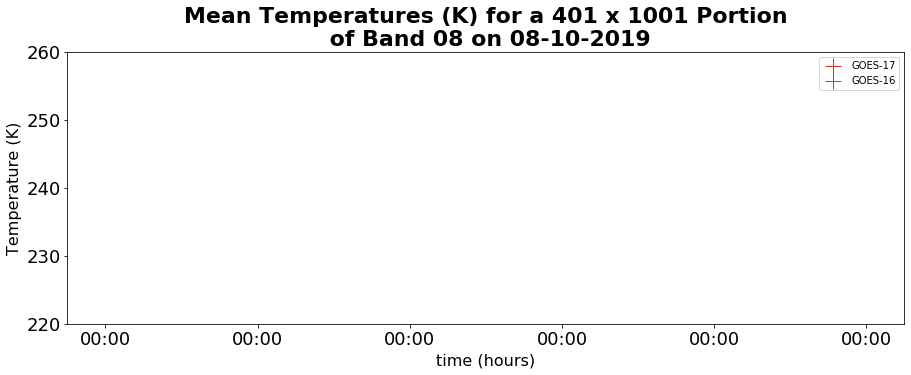

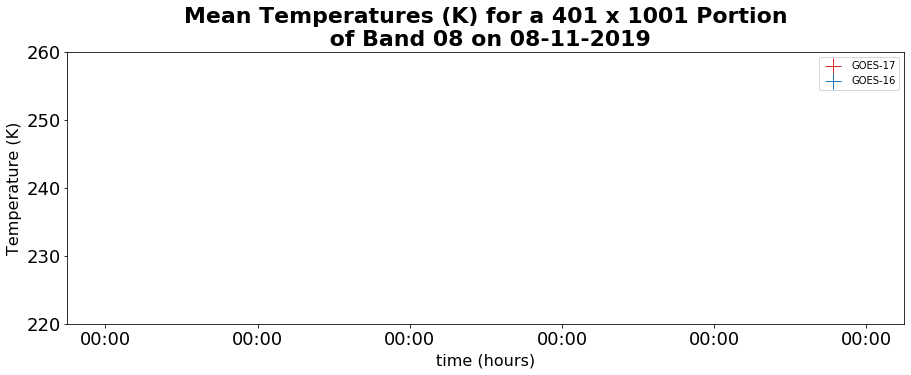

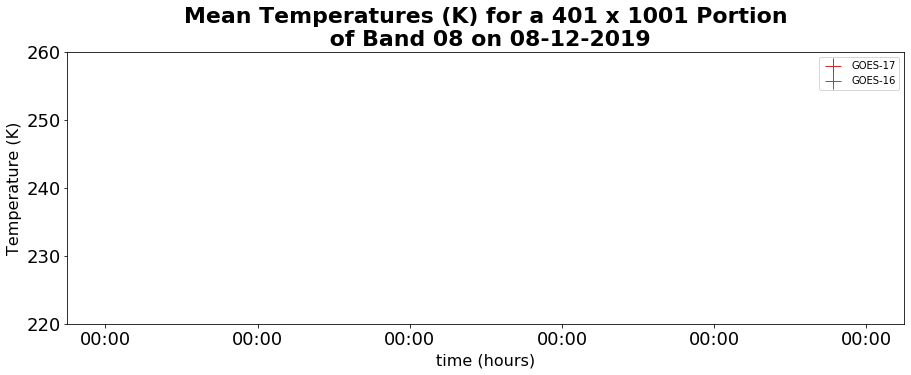

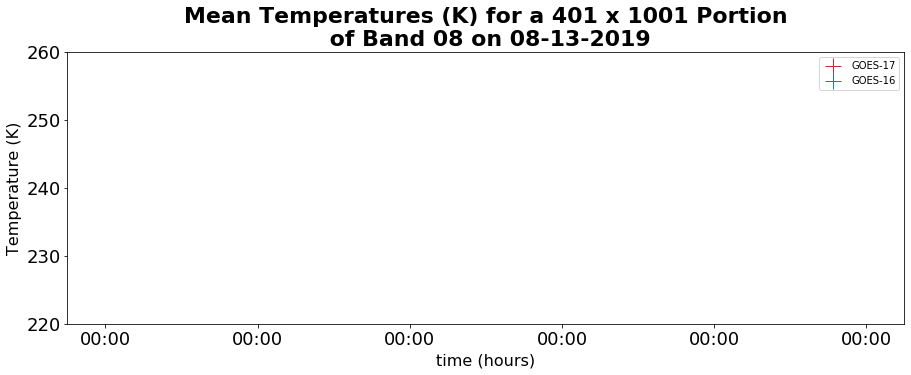

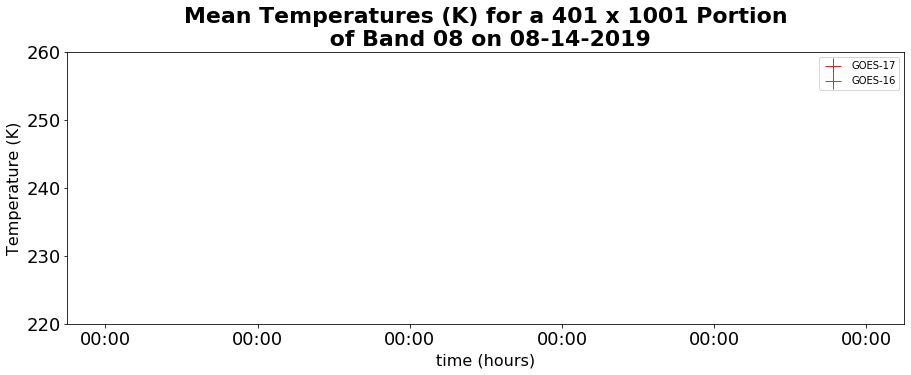

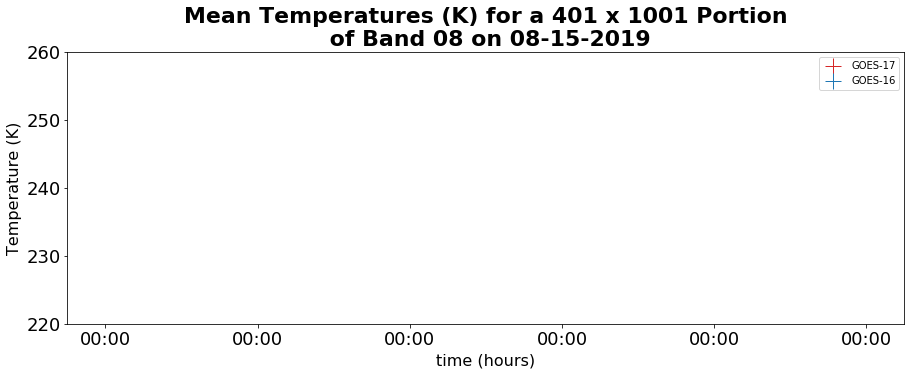

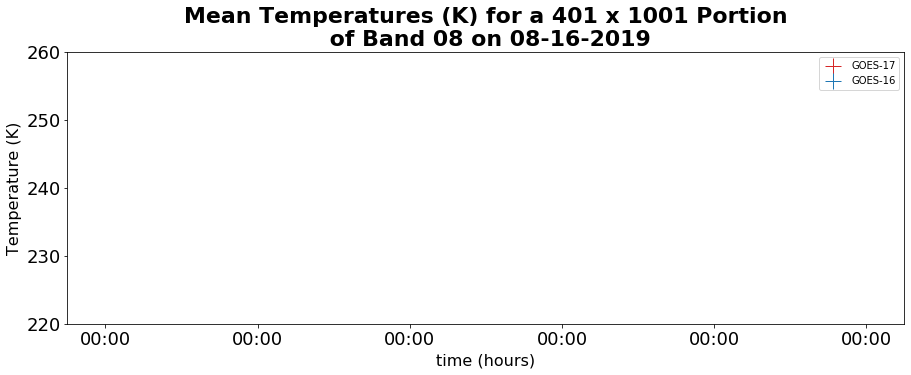

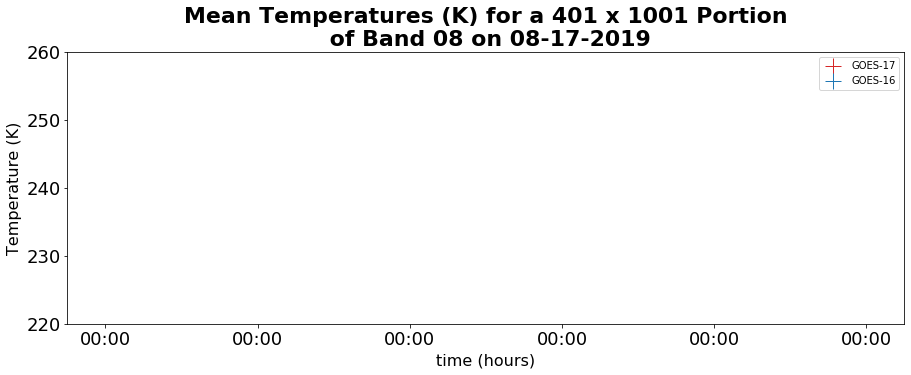

In [20]:

for i in [8]:
    for j in range(221,230):
        band = str(i).zfill(2)
        day = str(j).zfill(3)
        #OR_ABI-L1b-RadF-M6C{bb}_G{SS}_s2019{day}
        times17, mean17 = getTmean2('17', npPath, band, day)
        times16, mean16 = getTmean2('16', npPath, band, day)
    
        ptimes17 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times17]
        ptimes16 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times16]
        fig, ax1 = plt.subplots(figsize=(15,5))#constrained_layout=False
        _ = ax1.plot_date(ptimes17, mean17 , label="GOES-17", color='tab:red', 
                          marker='+', markersize = 16)
        _ = ax1.plot_date(ptimes16, mean16 , label='GOES-16', color='tab:blue', 
                          marker='+', markersize = 16, zorder=-1)
        _ = ax1.set_ylim(220,260)
        _ = ax1.tick_params('both', labelsize=18)
        _ = ax1.legend()
        _ = ax1.set_title(f'Mean Temperatures (K) for a 401 x 1001 Portion\n of Band 08 on 08-{str(9-221+j)}-2019', 
                          fontweight ='bold', fontsize = 22)
        _ = ax1.set_ylabel('Temperature (K)',fontsize = 16)
        _ = ax1.set_xlabel('time (hours)',fontsize = 16)
        _ = ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        a = f"goes17_17means_minus_16means_versus_FPMTemps_2019{day}_"
        b = f"fd_band{band}_medium_"
        c = f"GOES17_FPMTemp_GOES16vsGOES17MeanDiff_FD_2019{day}_Band{band}.png"
        
        directory = a+b+c
        
        _ = plt.savefig('..'+ op.join('/goesdata/Fall_Plot',directory))
        

In [ ]:
Tmean = []
times = []
toi = ['0300','0910','1010','1350','1510','2100']
for (bb,dd) in list(itertools.product([8],range(221,230))):
    for SS in ['16','17']:
        bins = np.linspace(220,250,101)
        fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), 
                                 constrained_layout=True, sharey = True, sharex = True)
        fig.suptitle(f'GOES-{SS} ABI Band 8 {8+dd}-Apr-2019', 
                     fontsize = 22, fontweight = 'bold')
        DD = dd.zfill(3)
        lookup = f'M6C08_G{SS}_s2019{DD}'
        ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
        npFiles = [f for f in os.listdir(npPath) if re.search(lookup,f)]

        for ncf, npf in zip(ncFiles,npFiles):
            imageBox = np.load(op.join(npPath,npf))
            myFile = xr.open_dataset(op.join(ncPath,ncf))
            planck_fk1 = float(myFile['planck_fk1'].data)
            planck_fk2 = float(myFile['planck_fk2'].data) 
            planck_bc1 = float(myFile['planck_bc1'].data)                       
            planck_bc2 = float(myFile['planck_bc2'].data)     
            T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
            tString = ncf[34:38]
            times.append(tString)
            Tmean.append(T)

            if tString in toi:
                ax = axes[toi.index(tString)]
                hh = tString[:2]
                mm = tString[2:4]
                ax.set_title(f'{hh}:{mm}')
                ax.set_ylabel('density (unitless)',fontsize = 16)
                ax.set_xlabel('Temperature (K)', fontsize = 16)

                Tbox = Rad2BT(imageBox, planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                ax.hist(Tbox.ravel(), bins = bins, density = True, label = 'Temp dist.')
                #ax.plot([T,T], [0,0.3],'r', label = 'something')
                ax.axvline(T, color='r',label = 'NOAA avg.')
            axes[0].legend(loc='upper left')
        fig.savefig('..'+ op.join(DATAPATH,f'''http://data.ssec.wisc.edu/abi/16band_stats/
                                  Histograms/2019{DD}/'''))